# **✦︎ Fine-Tuning SigLIP 2 for Image Classification**

This Colab notebook demonstrates how to fine-tune **[SigLIP 2](https://huggingface.co/google/siglip2-base-patch16-224)** — a powerful multilingual vision-language model — for **single-label image classification** tasks.

Aslo it integrates techniques like captioning-based pretraining, self-distillation, and masked prediction into a unified training pipeline.

---

**🤗 Type 1: Dataset with Train & Test Splits**

In this configuration, the dataset is already organized into separate training and testing splits. This setup is ideal for straightforward supervised learning workflows.

    Training Phase:
    The model is fine-tuned exclusively on the train split, where each image is paired with its corresponding class label.

    Evaluation Phase:
    After training, the model's performance is assessed on the test split to measure generalization accuracy.

✅ This approach is best suited for standard image classification tasks where the goal is to learn a discriminative mapping from images to labels using clearly separated train/test data.

**1. Install the packages**

In [ ]:
%%capture
!pip install evaluate datasets==3.2.0 accelerate
!pip install transformers==4.50.0 torchvision
!pip install huggingface-hub==0.31.0 hf_xet
#Hold tight, this will take around 2-3 minutes.

**Dataset ID2Label Mapping**

Note : The `id2label` mapping shows how numerical class IDs correspond to human-readable labels.  
This is **not required** for training or evaluation — it's just for **visual reference** and **debugging**.

    To demonstrate the finetuning process, we will use the MNIST dataset of handwritten digit images for classification.
    You can find the MNIST dataset here: https://huggingface.co/datasets/ylecun/mnist

In [ ]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("ylecun/mnist")

# Extract unique labels
labels = dataset["train"].features["label"].names

# Create id2label mapping
id2label = {str(i): label for i, label in enumerate(labels)}

# Print the mapping
print(id2label)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

{'0': '0', '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9'}


**2. Import modules required for data manipulation, model training, and image preprocessing.**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import gc
import numpy as np
import pandas as pd
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, f1_score
from imblearn.over_sampling import RandomOverSampler
import evaluate
from datasets import Dataset, Image, ClassLabel
from transformers import (
    TrainingArguments,
    Trainer,
    DefaultDataCollator
)

from transformers import AutoImageProcessor
from transformers import SiglipForImageClassification
from transformers.image_utils import load_image

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomRotation,
    RandomResizedCrop,
    RandomHorizontalFlip,
    RandomAdjustSharpness,
    Resize,
    ToTensor
)

from PIL import Image, ExifTags
from PIL import Image as PILImage
from PIL import ImageFile
# Enable loading truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

**3. Loading and Preparing the Dataset**

In [ ]:
from datasets import load_dataset
dataset = load_dataset("ylecun/mnist", split="train")

from pathlib import Path

file_names = []
labels = []

for example in dataset:
    file_path = str(example['image'])
    label = example['label']

    file_names.append(file_path)
    labels.append(label)

print(len(file_names), len(labels))

60000 60000


**4. Creating a DataFrame and Balancing the Dataset & Working with a Subset of Labels**

> Manual Label List (for Custom Naming & Mapping Consistency)

We manually define the `labels_list` to:

    Avoid auto-mapping issues that may arise due to inconsistent label formats in the dataset.

    Support flexible naming conventions, especially when label names need to follow a specific format or order.

    Ensure consistent behavior across different tools (like `ClassLabel`, Hugging Face datasets, and visualization libraries).


In [ ]:
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})
print(df.shape)

df.head()
df['label'].unique()

y = df[['label']]
df = df.drop(['label'], axis=1)
ros = RandomOverSampler(random_state=83)
df, y_resampled = ros.fit_resample(df, y)
del y
df['label'] = y_resampled
del y_resampled
gc.collect()

labels_subset = labels[:5]
print(labels_subset)

#labels_list = ['example_label_0', 'example_label_1'................,'example_label_n-1']
labels_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

label2id, id2label = {}, {}
for i, label in enumerate(labels_list):
    label2id[label] = i
    id2label[i] = label

ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

(60000, 2)
[5, 0, 4, 1, 9]
Mapping of IDs to Labels: {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9'} 

Mapping of Labels to IDs: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}


**5. Mapping and Casting Labels**

In [ ]:
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

**6. Splitting the Dataset**

In [ ]:
dataset = dataset.map(map_label2id, batched=True)
dataset = dataset.cast_column('label', ClassLabels)
dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")

train_data = dataset['train']
test_data = dataset['test']

Map:   0%|          | 0/60000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/60000 [00:00<?, ? examples/s]

**7. Setting Up the Model and Processor**

In [ ]:
model_str = "google/siglip2-base-patch16-224"
processor = AutoImageProcessor.from_pretrained(model_str)

# Extract preprocessing parameters
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


**8. Defining Data Transformations**

In [ ]:
# Define training transformations
_train_transforms = Compose([
    Resize((size, size)),
    RandomRotation(90),
    RandomAdjustSharpness(2),
    ToTensor(),
    Normalize(mean=image_mean, std=image_std)
])

# Define validation transformations
_val_transforms = Compose([
    Resize((size, size)),
    ToTensor(),
    Normalize(mean=image_mean, std=image_std)
])

**9. Applying Transformations to the Dataset**

In [ ]:
# Apply transformations to dataset
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Assuming train_data and test_data are loaded datasets
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

**10. Creating a Data Collator**

In [ ]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

**11. Initializing the Model**

In [ ]:
model = SiglipForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))
model.config.id2label = id2label
model.config.label2id = label2id

print(model.num_parameters(only_trainable=True) / 1e6)

config.json:   0%|          | 0.00/253 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

Some weights of SiglipForImageClassification were not initialized from the model checkpoint at google/siglip2-base-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


92.891914


**12. Defining Metrics and the Compute Function**

In [ ]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    label_ids = eval_pred.label_ids

    predicted_labels = predictions.argmax(axis=1)
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']

    return {
        "accuracy": acc_score
    }

**13. Setting Up Training Arguments**

In [ ]:
args = TrainingArguments(
    output_dir="siglip2-image-classification/",
    logging_dir='./logs',
    evaluation_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=4,
    report_to="none"
)

**14. Initializing the Trainer**

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

**15. Evaluating, Training, and Predicting**

In [ ]:
trainer.evaluate()

trainer.train()

trainer.evaluate()

outputs = trainer.predict(test_data)
print(outputs.metrics)

{'test_loss': 0.04699030518531799, 'test_model_preparation_time': 0.0025, 'test_accuracy': 0.98825, 'test_runtime': 306.2919, 'test_samples_per_second': 78.357, 'test_steps_per_second': 9.795}


**16. Computing Additional Metrics and Plotting the Confusion Matrix**

Accuracy: 0.9882
F1 Score: 0.9881


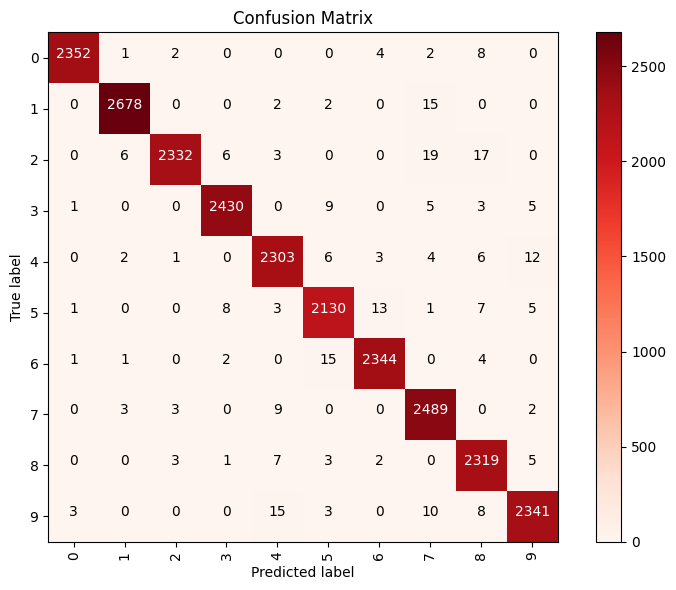


Classification report:

              precision    recall  f1-score   support

           0     0.9975    0.9928    0.9951      2369
           1     0.9952    0.9930    0.9941      2697
           2     0.9962    0.9786    0.9873      2383
           3     0.9931    0.9906    0.9918      2453
           4     0.9833    0.9855    0.9844      2337
           5     0.9825    0.9825    0.9825      2168
           6     0.9907    0.9903    0.9905      2367
           7     0.9780    0.9932    0.9855      2506
           8     0.9777    0.9910    0.9843      2340
           9     0.9878    0.9836    0.9857      2380

    accuracy                         0.9882     24000
   macro avg     0.9882    0.9881    0.9881     24000
weighted avg     0.9883    0.9882    0.9883     24000



In [ ]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Reds, figsize=(10, 8)):

    plt.figure(figsize=figsize)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

if len(labels_list) <= 150:
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

**17. Saving the Model and Uploading to Hugging Face Hub**

In [ ]:
trainer.save_model()

In [ ]:
from huggingface_hub import notebook_login, HfApi
notebook_login()

In [ ]:
api = HfApi()
repo_id = f"prithivMLmods/Mnist-Digits-SigLIP2"

api.upload_folder(
    folder_path="siglip2-image-classification/",
    path_in_repo=".",
    repo_id=repo_id,
    repo_type="model",
    revision="main"
)

Uploading...:   0%|          | 0.00/2.49G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/prithivMLmods/mnist_siglip2/commit/5e3eb7bd47f6fe10c0637de53b2d46cf3dcf83ce', commit_message='Upload folder using huggingface_hub', commit_description='', oid='5e3eb7bd47f6fe10c0637de53b2d46cf3dcf83ce', pr_url=None, repo_url=RepoUrl('https://huggingface.co/prithivMLmods/mnist_siglip2', endpoint='https://huggingface.co', repo_type='model', repo_id='prithivMLmods/mnist_siglip2'), pr_revision=None, pr_num=None)

> **Quickstart Demo with Transformers🤗 & Gradio**

This demo uses a fine-tuned **SigLIP 2** model to classify handwritten digits from the **MNIST** dataset. Powered by Transformers and Gradio, it provides an interactive interface for real-time predictions.

In [ ]:
%%capture
!pip install gradio

In [ ]:
import gradio as gr
from transformers import AutoImageProcessor, SiglipForImageClassification
from transformers.image_utils import load_image
from PIL import Image
import torch

# Load model and processor
model_name = "prithivMLmods/Mnist-Digits-SigLIP2" # Alter your model path
model = SiglipForImageClassification.from_pretrained(model_name)
processor = AutoImageProcessor.from_pretrained(model_name)

def classify_digit(image):
    """Predicts the digit in the given handwritten digit image."""
    image = Image.fromarray(image).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1).squeeze().tolist()

    #-------------------------------------------------------------------------#
    # Modify the label list to match your model's setup
    labels = {
        "0": "0", "1": "1", "2": "2", "3": "3", "4": "4",
        "5": "5", "6": "6", "7": "7", "8": "8", "9": "9"
    }
    predictions = {labels[str(i)]: round(probs[i], 3) for i in range(len(probs))}

    return predictions
    #-------------------------------------------------------------------------#

# Create Gradio interface
iface = gr.Interface(
    fn=classify_digit,
    inputs=gr.Image(type="numpy"),
    outputs=gr.Label(label="Prediction Scores"),
    title="MNIST Digit Classification 🔢",
    description="Upload a handwritten digit image (0-9) to recognize it using MNIST-Digits-SigLIP2."
)

# Launch the app
if __name__ == "__main__":
    iface.launch()

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/372M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f4a078c41f01f49878.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


**Demo Inference Screenshots**

The demo inference screenshots are provided below for your reference.  
These examples showcase the model’s predictions on sample inputs after fine-tuning.

> 🧪 Feel free to try your own examples in the Colab notebook!

| ![Screenshot 1](https://cdn-uploads.huggingface.co/production/uploads/65bb837dbfb878f46c77de4c/QWzvjpAr5NpggQFPQsmjw.png) | ![Screenshot 2](https://cdn-uploads.huggingface.co/production/uploads/65bb837dbfb878f46c77de4c/ED1J2V4T51y-3vFcEiCK2.png) |
|:--:|:--:|
| ![Screenshot 3](https://cdn-uploads.huggingface.co/production/uploads/65bb837dbfb878f46c77de4c/YdCllznr25S3kVXwRTzOi.png) | ![Screenshot 4](https://cdn-uploads.huggingface.co/production/uploads/65bb837dbfb878f46c77de4c/Zozc8LQoSBoqjGvyqBkwy.png) |



This notebook provides a complete pipeline to fine-tune **SigLIP 2** for single-label image classification tasks.  
By leveraging advanced training techniques like **captioning-based pretraining**, **self-distillation**, and **masked prediction**, you can boost performance on a wide range of datasets. Whether you're working with multilingual labels, imbalanced classes, or custom naming schemes, this setup is flexible and ready for experimentation.

    You can find the fine-tuned model here: https://huggingface.co/prithivMLmods/Mnist-Digits-SigLIP2

Ready to adapt for your own datasets and downstream tasks!

**🎉 Happy Fine-Tuning!**

> **Made with 🤗 x ❤️ by [Prithiv Sakthi](https://www.linkedin.com/in/prithiv-sakthi/)**

Feel free to fork, modify, and explore!